In [36]:
import sympy as sp
import numpy as np
from IPython.display import display, Math
from sympy import pprint,simplify, expand, sstr, latex
from matplotlib import pyplot as plt

In [37]:
def cos_to_sin2_halfangle(expr: sp.Expr) -> sp.Expr:
    """Replace cos(u) -> 1 - 2*sin(u/2)**2 everywhere (no phase shift)."""
    u = sp.Wild('u')
    out = expr.replace(sp.cos(u), 1 - 2*sp.sin(u/2)**2)
    expr = str(sp.expand(out))
    return (expr
    )

In [38]:
def pretty_s(expr):
    expr = str(expr)
    return (expr
        .replace("**6", "⁶")
        .replace("**5", "⁵")
        .replace("**4", "⁴")
        .replace("**3", "³")
        .replace("**2", "²")
        .replace("*", "")
    )

In [39]:
def sin_theta_from_tan2_all(tan2theta, theta):
    r = sp.sqrt(1 / (1 + tan2theta**2))
    
    sin_branches = [
        sp.sqrt((1 + r) / 2),
        -sp.sqrt((1 + r) / 2),
        sp.sqrt((1 - r) / 2),
        -sp.sqrt((1 - r) / 2),
    ]
    cos_branches = [
        sp.sqrt((1 - r)/2),
        -sp.sqrt((1 - r)/2),
        sp.sqrt((1 + r)/2),
        -sp.sqrt((1 + r)/2),
    ]

    #equations = [sp.Eq(sp.sin(theta), b) for b in branches]
    #equations = [sp.Eq(sp.sin(theta), sp.simplify(b)) for b in branches]

    for i, (s, c) in enumerate(zip(sin_branches, cos_branches), 1):
        print(f"\nBranch {i}:")
        sp.pprint(sp.Eq(sp.sin(theta), sp.simplify(s)))
        sp.pprint(sp.Eq(sp.cos(theta), sp.simplify(c)))

In [48]:
def Neutron_Osc_Prob(n, H, S, eta_n, eps_n, t_n ):
    """Replace cos(u) -> 1 - 2*sin(u/2)**2 everywhere (no phase shift)."""
    m, t, eps, eta = sp.symbols('m t ε η', real=True)
    R=sp.Rational
    I=sp.eye(n)
    H_D=sp.simplify(S.T@H@S)
    H_D_R=H_D-m*I
    S_diag=sp.simplify(S*sp.exp(-sp.I*H_D_R*t)*S.H)
    P_n=sp.zeros(n)
    for i in range(n):
        for j in range (n):
            P_n[i,j]=sp.simplify(sp.expand_complex(S_diag[i,j]*S_diag[i,j].conjugate().rewrite(sp.sin)))
    s=0
    for i in range(n):
        s=s+P_n[0,i]
    s=sp.simplify(s)
    p_n_sin = P_n.applyfunc(cos_to_sin2_halfangle)
    display(Math(r"H=" + sp.latex(H)))
    display(Math(r"S=" + sp.latex(S)))
    display(Math(r"S_{diag}=" + sp.latex(S_diag)))
    for i in range(n):
        for j in range(n):
            display(Math(rf"P{n}_{{{i}{j}}}=" + sp.latex(p_n_sin[i, j])))
    P_n_approx = p_n_sin.applyfunc(lambda e: sp.series(e, t, 0, 9).removeO())
    
    
    params = {
    eps: eps_n,
    eta: eta_n,
    m: 1.0
            }
    
    P_dict = {}
    
    P_dict[rf"$P(n\to n)$"] = P_n[0, 0]
    P_dict[rf"$P(n\to \bar n)$"] = P_n[0, 1]
    for k in range(2, n):
        if k % 2 == 0:
        # n_k → n_1
            P_dict[rf"$P(n_\to n_{k//2})$"] = P_n[0, k]
        else:
        # n̄_k → n_1
            P_dict[rf"$P(n\to \bar n_{int(k // 2)})$"] = P_n[0, k]
    P_funcs = {
        label: sp.lambdify(t, expr.subs(params), "numpy")
    for label, expr in P_dict.items()
        }
    t_vals = np.linspace(0, t_n, 1000)
    plt.figure(figsize=(8,5))

    for label, f in P_funcs.items():
        y = np.asarray(f(t_vals), dtype=float)

        if np.allclose(y, 0.0):
            continue
        plt.plot(t_vals, f(t_vals), label=label)
        
#plt.plot(t_vals, np.ones_like(t_vals), 'k--', linewidth=2, label=r"$s=1$")
    s_simpl2 = sp.trigsimp(s)

    s_num_expr = sp.simplify(s_simpl2.subs(params))


    s_func = sp.lambdify(t, s_num_expr, "numpy")


    y = s_func(t_vals)
    y = np.full_like(t_vals, y, dtype=float) if np.isscalar(y) else y
    plt.plot(t_vals, y, 'k--', linewidth=2, label=r"$s(t)=\sum P$")

    plt.xlabel(r"$t$", fontsize=16)
    plt.ylabel(r"$P(t)$", fontsize=16)
    plt.legend(fontsize=16, loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    display(Math(rf"s=" + sp.latex(sp.simplify(s))))
    return (H_D_R
    )

# 3 Family

In [43]:
R=sp.Rational
m, t, eps, eta = sp.symbols('m t ε η', real=True)
H = sp.Matrix([[m, 0, 0, eps, 0, eps],
               [0, m, eps, 0, eps, 0],
               [0, eps, m, 0, 0, eps],
               [eps, 0, 0, m, eps, 0],
               [0, eps, 0,eps,m,0],
               [eps, 0, eps, 0, 0, m]])
U_nnbar = sp.Matrix([
    [ sp.sqrt(2)*R(1,2), -sp.sqrt(2)*R(1,2), 0, 0, 0, 0 ],
    [ sp.sqrt(2)*R(1,2),  sp.sqrt(2)*R(1,2), 0, 0, 0, 0 ],

    [ 0, 0,  sp.sqrt(2)*R(1,2), -sp.sqrt(2)*R(1,2), 0, 0 ],
    [ 0, 0,  sp.sqrt(2)*R(1,2),  sp.sqrt(2)*R(1,2), 0, 0 ],

    [ 0, 0, 0, 0,  sp.sqrt(2)*R(1,2), -sp.sqrt(2)*R(1,2) ],
    [ 0, 0, 0, 0,  sp.sqrt(2)*R(1,2),  sp.sqrt(2)*R(1,2) ],
])

# Optional: check unitarity
U_131= sp.Matrix([
    [sp.sqrt(2)*R(1,2), 0, sp.sqrt(2)*R(1,2), 0, 0, 0],
    [0,  sp.sqrt(2)*R(1,2), 0, -sp.sqrt(2)*R(1,2), 0, 0],
    [-sp.sqrt(2)*R(1,2), 0, sp.sqrt(2)*R(1,2), 0, 0, 0],
    [0, sp.sqrt(2)*R(1,2), 0, sp.sqrt(2)*R(1,2), 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0,  0, 0, 0, 0,  1]
])
U_11=sp.sqrt(3)*R(1,3)
U_22=U_11
U_12=(sp.sqrt(6))*R(1,3)
U_21=-U_12
U_3526= sp.Matrix([
    [1, 0, 0, 0, 0, 0],
    [0,  U_11, 0, 0,0, U_12 ],
    [0, 0, U_11, 0, U_12, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, U_21, 0, U_22, 0],
    [0,  U_21, 0, 0, 0,  U_22]
])
S = sp.simplify(U_nnbar@U_131@U_3526)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

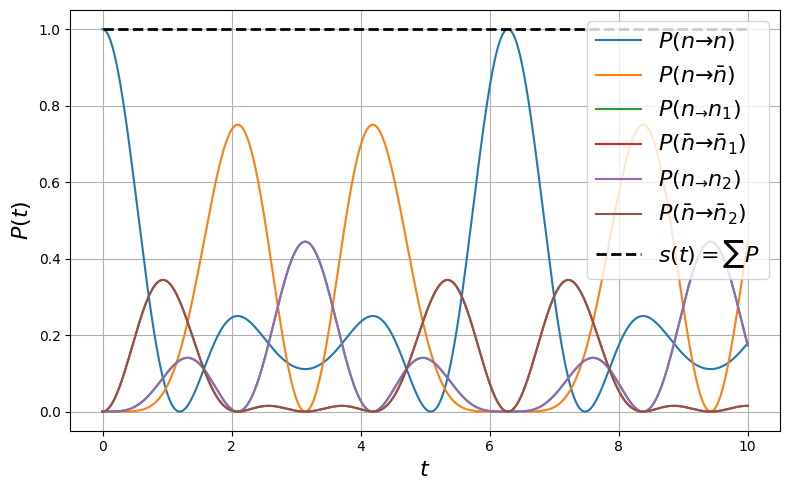

<IPython.core.display.Math object>

Matrix([
[-ε, 0,  0, 0,   0,    0],
[ 0, ε,  0, 0,   0,    0],
[ 0, 0, -ε, 0,   0,    0],
[ 0, 0,  0, ε,   0,    0],
[ 0, 0,  0, 0, 2*ε,    0],
[ 0, 0,  0, 0,   0, -2*ε]])

In [44]:
Neutron_Osc_Prob(6, H, S, 2, 1, 10)

In [8]:
#S

In [9]:
#H

# 2 Family

In [41]:
H = sp.Matrix([[m, 0, 0, eps],
               [0, m, eps, 0],
               [0, eps, m, 0], 
               [eps, 0, 0, m]])
U_nnbar_44= sp.Matrix([
    [ sp.sqrt(2)*R(1,2), -sp.sqrt(2)*R(1,2), 0, 0 ],
    [ sp.sqrt(2)*R(1,2),  sp.sqrt(2)*R(1,2), 0, 0 ],

    [ 0, 0,  sp.sqrt(2)*R(1,2), -sp.sqrt(2)*R(1,2) ],
    [ 0, 0,  sp.sqrt(2)*R(1,2),  sp.sqrt(2)*R(1,2) ]
])

sp.simplify(U_nnbar_44)
U_1324_44= sp.Matrix([
    [sp.sqrt(2)*R(1,2), 0, sp.sqrt(2)*R(1,2), 0],
    [0,  sp.sqrt(2)*R(1,2), 0, -sp.sqrt(2)*R(1,2)],
    [-sp.sqrt(2)*R(1,2), 0, sp.sqrt(2)*R(1,2), 0],
    [0, sp.sqrt(2)*R(1,2), 0, sp.sqrt(2)*R(1,2)],
])
S=U_nnbar_44@U_1324_44

In [11]:
S

Matrix([
[ 1/2, -1/2, 1/2,  1/2],
[ 1/2,  1/2, 1/2, -1/2],
[-1/2, -1/2, 1/2, -1/2],
[-1/2,  1/2, 1/2,  1/2]])

In [12]:
# with mixing
H = sp.Matrix([[m, 0, eta, eps],
               [0, m, eps, eta],
               [eta, eps, m, 0],
               [eps, eta, 0, m]])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

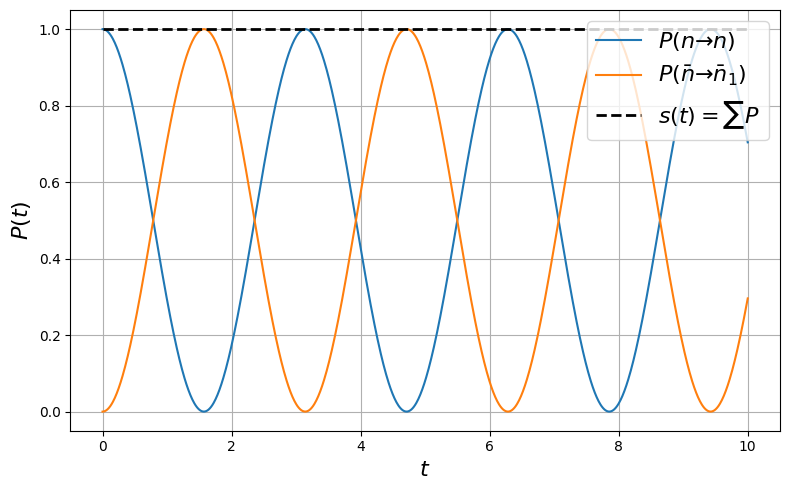

<IPython.core.display.Math object>

Matrix([
[-ε,  0, 0, 0],
[ 0, -ε, 0, 0],
[ 0,  0, ε, 0],
[ 0,  0, 0, ε]])

In [42]:
Neutron_Osc_Prob(4, H, S, 2, 1, 10)

# 4 Family

In [14]:
H = sp.Matrix([[m, 0, 0, eps, 0, eps, 0, eps],
               [0, m, eps, 0, eps, 0, eps, 0],
               [0, eps, m, 0, 0, eps, 0, eps],
               [eps, 0, 0, m, eps, 0, eps, 0],
               [0, eps, 0,eps, m, 0, 0, eps],
               [eps, 0, eps, 0, 0, m, eps, 0],
               [0, eps, 0, eps, 0, eps, m, 0],
               [eps, 0, eps, 0, eps, 0, 0, m]])

In [45]:
S_88_1=sp.Matrix([
    [ sp.sqrt(2)*R(1,2), -sp.sqrt(2)*R(1,2), 0, 0, 0, 0, 0, 0 ],
    [ sp.sqrt(2)*R(1,2),  sp.sqrt(2)*R(1,2), 0, 0, 0, 0, 0, 0 ],

    [ 0, 0,  sp.sqrt(2)*R(1,2), -sp.sqrt(2)*R(1,2), 0, 0, 0, 0 ],
    [ 0, 0,  sp.sqrt(2)*R(1,2),  sp.sqrt(2)*R(1,2), 0, 0, 0, 0 ],

    [ 0, 0, 0, 0,  sp.sqrt(2)*R(1,2), -sp.sqrt(2)*R(1,2), 0, 0 ],
    [ 0, 0, 0, 0,  sp.sqrt(2)*R(1,2),  sp.sqrt(2)*R(1,2), 0, 0 ],
    
    [0, 0, 0, 0, 0, 0, sp.sqrt(2)*R(1,2), -sp.sqrt(2)*R(1,2) ],
    [0, 0, 0, 0, 0, 0, sp.sqrt(2)*R(1,2), sp.sqrt(2)*R(1,2) ]
])

S_88_2=sp.Matrix([
    [sp.sqrt(2)*R(1,2), 0, sp.sqrt(2)*R(1,2), 0, 0, 0, 0, 0],
    [0,  sp.sqrt(2)*R(1,2), 0, -sp.sqrt(2)*R(1,2), 0, 0, 0, 0],
    [-sp.sqrt(2)*R(1,2), 0, sp.sqrt(2)*R(1,2), 0, 0, 0, 0, 0],
    [0, sp.sqrt(2)*R(1,2), 0, sp.sqrt(2)*R(1,2), 0, 0, 0, 0],
    [0, 0, 0, 0, sp.sqrt(2)*R(1,2), 0, sp.sqrt(2)*R(1,2), 0],
    [0,  0, 0, 0, 0,  sp.sqrt(2)*R(1,2), 0, -sp.sqrt(2)*R(1,2)],
    [0, 0, 0, 0, -sp.sqrt(2)*R(1,2), 0, sp.sqrt(2)*R(1,2), 0],
    [0, 0, 0, 0, 0, sp.sqrt(2)*R(1,2), 0, sp.sqrt(2)*R(1,2)]
])

S_88_3=sp.Matrix([
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0,  sp.sqrt(2)*R(1,2), 0, 0, 0, -sp.sqrt(2)*R(1,2), 0, 0],
    [0, 0, sp.sqrt(2)*R(1,2), 0, 0, 0, sp.sqrt(2)*R(1,2), 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0,  sp.sqrt(2)*R(1,2), 0, 0, 0,  sp.sqrt(2)*R(1,2), 0, 0],
    [0, 0, -sp.sqrt(2)*R(1,2), 0, 0, 0, sp.sqrt(2)*R(1,2), 0],
    [0, 0, 0, 0, 0, 0, 0, 1]
])
S=S_88_1@S_88_2@S_88_3

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

AttributeError: 'Text' object has no property 'fontsiize'

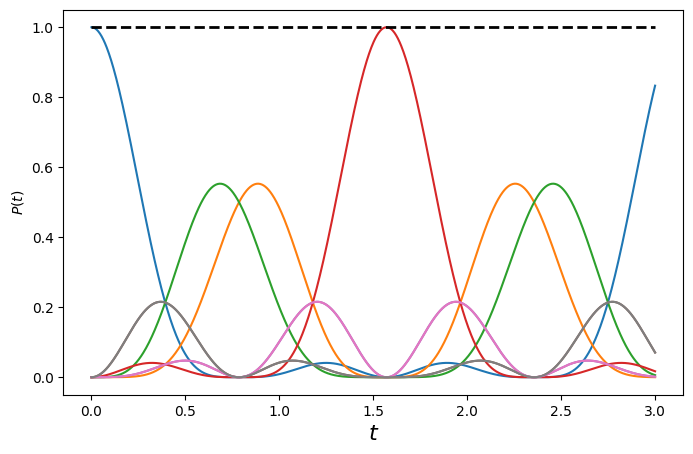

In [21]:
Neutron_Osc_Prob(8, H, S, 2, 1, 3 )

# 4 Family, eta, eps

In [50]:
H=sp.Matrix([[m, 0, 0, eps, 0, eta, 0, eta],
             [0, m, eps, 0, eta, 0, eta, 0],
             [0, eps, m, 0, 0, eta, 0, eta],
             [eps, 0, 0, m, eta, 0, eta, 0],
             [0, eta, 0, eta, m, 0, 0, eps],
             [eta, 0, eta, 0, 0, m, eps, 0],
             [0, eta, 0, eta, 0, eps, m, 0],
             [eta, 0, eta, 0, eps, 0, 0, m]])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

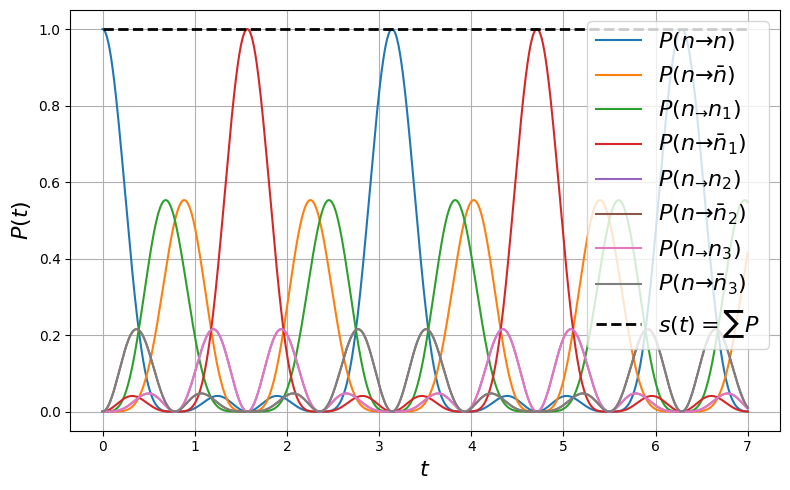

<IPython.core.display.Math object>

Matrix([
[-ε,        0,       0, 0,  0,        0,       0, 0],
[ 0, -ε - 2*η,       0, 0,  0,        0,       0, 0],
[ 0,        0, ε - 2*η, 0,  0,        0,       0, 0],
[ 0,        0,       0, ε,  0,        0,       0, 0],
[ 0,        0,       0, 0, -ε,        0,       0, 0],
[ 0,        0,       0, 0,  0, -ε + 2*η,       0, 0],
[ 0,        0,       0, 0,  0,        0, ε + 2*η, 0],
[ 0,        0,       0, 0,  0,        0,       0, ε]])

In [51]:
Neutron_Osc_Prob(8, H, S, 2, 1, 7)

# 5 Family